## Data description: variabilitiy in 1600-year time slices

Author: Karin van der Wiel, 09-08-2022

Aim: test to what extent the assumption of 'full variability within a time slice' holds


#### Preparation

In [1]:
## import packages
import xarray as xr
import numpy as np
from scipy.stats import genextreme as gev
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

## data locations
output_directory='/net/pc170544/nobackup/users/wiel/LENTIS/datapaper/'

In [2]:
VAR = 'tas'
TIME = 'day'
LOC = '52.3N_4.9E'

#### Open data

In [3]:
da_PD = xr.open_dataset(f"{output_directory}/{VAR}_{TIME}_PD_{LOC}.nc")[VAR].load()
da_2K = xr.open_dataset(f"{output_directory}/{VAR}_{TIME}_2K_{LOC}.nc")[VAR].load()

# convert units
if VAR == 'tas':
    da_PD = da_PD - 273.15
    da_2K = da_2K - 273.15
    
# split in two halves (by member/seed to get most similar groups in terms of parent/time)
da_p1 = da_PD[:,::2,:]
da_p2 = da_PD[:,1::2,:]

#da_p1 = da[::2,:,:]; da_p2 = da[1::2,:,:]             # test if we split along parents
#da_p1 = da[:,:,0:1826]; da_p2 = da[:,:,1827:1826*2]   # test if we split along time axis (equal length required by code further down)

#### Preprocess

In [4]:
def find_blockmaxima(da,season,type='max'):
    if season in ['MAM','JJA','SON']:
        da_season = da.where(da.time.dt.season==season).dropna(dim='time')
    elif season in ['DJF']:
        print('ERROR SHIFT TIME AXIS ZERO POINT TO GET PROPER DJF!!!')
        da_season = da.where(da.time.dt.season==season).dropna(dim='time')
    elif season == 'ann':
        da_season = da
    if type == 'max':
        return da_season.groupby(da_season.time.dt.year).max()
    elif type == 'min': 
        return da_season.groupby(da_season.time.dt.year).min()
    else:
        print("'type' currently undefined")
def fit_gev(da):
    shape, loc, scale = gev.fit(da)
    GEV_distr_x = np.linspace(loc - (scale / shape), loc + (scale / shape), num=100)
    GEV_distr_y = gev.pdf(GEV_distr_x, shape, loc, scale)
    GEV_returntimes = np.arange(10,1600)
    GEV_returnlevels = gev.isf(1/GEV_returntimes, shape, loc, scale)
    return GEV_distr_x,GEV_distr_y,GEV_returntimes,GEV_returnlevels
def fit_kde(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

np_PD = np.reshape(da_PD.values,(len(da_PD.parent)*len(da_PD.member)*len(da_PD.time)))
np_p1 = np.reshape(da_p1.values,(len(da_p1.parent)*len(da_p1.member)*len(da_p1.time)))
np_p2 = np.reshape(da_p2.values,(len(da_p2.parent)*len(da_p2.member)*len(da_p2.time)))
np_2K = np.reshape(da_2K.values,(len(da_2K.parent)*len(da_2K.member)*len(da_2K.time)))

if VAR == 'tas':  kde_bins = np.arange(-15,35,.5)
kde_PD = fit_kde(np_PD, kde_bins, bandwidth=.5)
kde_p1 = fit_kde(np_p1, kde_bins, bandwidth=.5)
kde_p2 = fit_kde(np_p2, kde_bins, bandwidth=.5)
kde_2K = fit_kde(np_2K, kde_bins, bandwidth=.5)

if VAR == 'tas':
    da_PD_warmestday = find_blockmaxima(da_PD,'ann')
    da_p1_warmestday = find_blockmaxima(da_p1,'ann')
    da_p2_warmestday = find_blockmaxima(da_p2,'ann')   
    da_2K_warmestday = find_blockmaxima(da_2K,'ann')    
    np_PD_warmestday = np.reshape(da_PD_warmestday.values,(len(da_PD_warmestday.parent)*len(da_PD_warmestday.member)*len(da_PD_warmestday.year)))
    np_p1_warmestday = np.reshape(da_p1_warmestday.values,(len(da_p1_warmestday.parent)*len(da_p1_warmestday.member)*len(da_p1_warmestday.year)))
    np_p2_warmestday = np.reshape(da_p2_warmestday.values,(len(da_p2_warmestday.parent)*len(da_p2_warmestday.member)*len(da_p2_warmestday.year)))
    np_2K_warmestday = np.reshape(da_2K_warmestday.values,(len(da_2K_warmestday.parent)*len(da_2K_warmestday.member)*len(da_2K_warmestday.year)))
    gev_distrX_PD, gev_distrY_PD, gev_rt_PD, gev_rl_PD = fit_gev(np_PD_warmestday)
    gev_distrX_p1,  gev_distrY_p1,  gev_rt_p1, gev_rl_p1 = fit_gev(np_p1_warmestday)
    gev_distrX_p2,  gev_distrY_p2,  gev_rt_p2, gev_rl_p2 = fit_gev(np_p2_warmestday)
    gev_distrX_2K,  gev_distrY_2K,  gev_rt_2K, gev_rl_2K = fit_gev(np_2K_warmestday)

/usr/people/wiel/miniconda3/envs/juplab/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2492: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


#### Plot figure

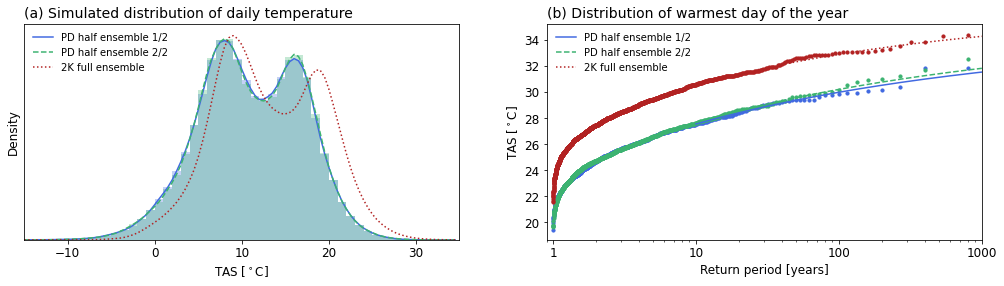

In [5]:
fig,ax1 = plt.subplots(figsize=(14,4))
plt.subplots_adjust(left=0.03, bottom=0.15, right=.98, top=0.9, hspace=.4)
colour1 = 'royalblue'
colour2 = 'mediumseagreen'
colour3 = 'firebrick'

# Distributions
ax = plt.subplot(1,2,1)

if VAR == 'tas':  hist_bins = np.arange(-19,33,1)
else:             hist_bins = 50
plt.hist(np_p1, hist_bins, density=True, histtype='stepfilled', facecolor=colour1, alpha=0.3)
plt.hist(np_p2, hist_bins, density=True, histtype='stepfilled', linewidth=0, facecolor=colour2, alpha=0.3)
#plt.plot(kde_bins, kde_PD, color='black', linewidth=.5, linestyle='--', label='PD full ensemble')
plt.plot(kde_bins, kde_p1, color=colour1, label='PD half ensemble 1/2')
plt.plot(kde_bins, kde_p2, color=colour2, linestyle='--', label='PD half ensemble 2/2')
plt.plot(kde_bins, kde_2K, color=colour3, linestyle=':', label='2K full ensemble')

#if VAR == 'tas':  bins = np.arange(250,310,.5)
#else:             bins = 50
#plt.hist(np_p1_warmestday, bins, density=True, histtype='bar', facecolor=colour1, alpha=0.3)
#plt.hist(np_p2_warmestday, bins, density=True, histtype='bar', facecolor=colour2, alpha=0.3)
#plt.hist(np_2K_warmestday, bins, density=True, histtype='bar', facecolor=colour2, alpha=0.3)
#plt.plot(gev_distrX_p1, gev_distrY_p1, colour1, label='PD half ensemble 1/2')
#plt.plot(gev_distrX_p2, gev_distrY_p2, label='PD half ensemble 2/2')
#plt.plot(gev_distrX_2K, gev_distrY_2K, colour3, label='2K full ensemble')
# annotation
plt.legend(frameon=False)
plt.title(f"(a) Simulated distribution of daily temperature",loc='left',fontsize=14)
plt.xlabel('TAS [$^\circ$C]',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.yticks([])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.ylim(0,0.072)
plt.xlim(-15,35)


# block maxima
ax = plt.subplot(1,2,2)
#N    = np.r_[1:len(np_PD_warmestday)+1]*1.0 #must *1.0 to convert int to float
#plt.scatter(max(N)/N, sorted(np_PD_warmestday)[::-1], s=10, color='black')
#plt.plot(gev_rt_PD, gev_rl_PD, color='black', label='PD full ensemble')
N    = np.r_[1:len(np_p1_warmestday)+1]*1.0 #must *1.0 to convert int to float
plt.scatter(max(N)/N, sorted(np_p1_warmestday)[::-1], s=10, color=colour1)
plt.plot(gev_rt_p1, gev_rl_p1, color=colour1, label='PD half ensemble 1/2')
plt.scatter(max(N)/N, sorted(np_p2_warmestday)[::-1], s=10, color=colour2)
plt.plot(gev_rt_p2, gev_rl_p2, color=colour2, linestyle='--', label='PD half ensemble 2/2')
N    = np.r_[1:len(np_2K_warmestday)+1]*1.0 #must *1.0 to convert int to float
plt.scatter(max(N)/N, sorted(np_2K_warmestday)[::-1], s=10, color=colour3)
ax.set_xscale('log')
plt.plot(gev_rt_2K, gev_rl_2K, color=colour3, linestyle=':', label='2K full ensemble')




# annotation
plt.title(f"(b) Distribution of warmest day of the year",loc='left',fontsize=14)
plt.xlabel('Return period [years]',fontsize=12)
plt.ylabel('TAS [$^\circ$C]',fontsize=12)
#plt.xticks([1,2,5,10,20,50,100,200,500,1000],['1','2','5','10','20','50','100','200','500','1000'])
plt.xticks([1,10,100,1000],['1','10','100','1000'])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim(.9,1000)
plt.legend(frameon=False)

plt.savefig(f"fig_datadescr_1600yrvar.pdf")
plt.show()

#### Some relevant values

In [6]:
text = f"Maximum difference GEV-fit for return periods [1-1000 yrs]:\n\ttwo half PD ensembles:\t\t{np.nanmax(abs(gev_rl_p1-gev_rl_p2)[2:1001]):.2f} K\n\tPD and 2K (full) ensembles:\t{np.nanmax(abs(gev_rl_PD-gev_rl_2K)[2:1001]):.2f} K"
print(text)


Maximum difference GEV-fit for return periods [1-1000 yrs]:
	two half PD ensembles:		0.29 K
	PD and 2K (full) ensembles:	2.91 K
